In [3]:
import os
import torch
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import Cityscapes
from torchvision import transforms 
from PIL import Image, ImageOps, ImageFilter
import random
from tqdm import tqdm
from cleanlab.filter import find_label_issues
import torchvision.transforms.functional as F
import pandas as pd
import time
import os.path as osp
from scipy.interpolate import interp1d

In [4]:
# !nvidia-smi

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
torch.cuda.empty_cache()

In [6]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
class Vector2():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __add__(self, other):
        return Vector2(self.x + other.x, self.y + other.y)
    def __sub__(self, other):
        return Vector2(self.x - other.x, self.y - other.y)
    def __mul__(self, other):
        return Vector2(self.x * other, self.y * other)

    def magnitude(self):
        return (self.x**2 + self.y**2) ** 0.5

    def unitV(self):
        if self.magnitude() == 0:
            return Vector2(0,0)
        return Vector2(self.x / self.magnitude(), self.y / self.magnitude())

    def dotP(self, other):
        return (self.x * other.x) + (self.y * other.y)

    @staticmethod
    def randomVector():
        return Vector2(random.uniform(-1, 1), random.uniform(-1, 1))

    def __str__(self):
        return "x = " + str(self.x) + " y = " + str(self.y)


def smooth_function(center, variance):
    x = np.linspace(0, 2*np.pi, num = 6, endpoint = True)
    y = np.random.normal(center, variance**0.5, 5)
    y = np.append(y, y[0])
    return interp1d(x, y, kind='cubic')


In [8]:
def perturb_nat(image, variance):
    center = 0
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #these are only needed for RBG images
    # ret, thresh = cv2.threshold(gray, 20, 255, 0)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    output = np.zeros(np.shape(image))
    if len(contours) == 0: #blank image
        return output

    for contour in contours:
        f = smooth_function(center, variance)
        size = len(contour)

        br = cv2.boundingRect(contour)
        cx = br[0] + br[2] / 2
        cy = br[1] + br[3] / 2
        center_point = Vector2(cx, cy)

        for count, point in enumerate(contour):
            x = (count / size) * 2 * np.pi
            distance_to_move = f(x)
            current_point = Vector2(point[0][0], point[0][1])
            direction = current_point - center_point
            direction = direction.unitV()
            offset = direction * distance_to_move
            contour[count][0] = [current_point.x - offset.x, current_point.y - offset.y]

        cv2.fillPoly(output, pts=[contour], color=1)
    return output

In [9]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabeled','sky', 'building', 'road', 'sidewalk', 'fence', 'vegetation','pole','car', \
               'traffic sign','person','bicycle','motorcycle','traffic light', 'terrain', \
               'rider',  'truck', 'bus', 'train','wall']

    def __init__(
            self, 
            root, 
            list_path,
            split=None, 
            mode=None,
            classes=None,
            target_type='semantic',
            augmentation=None, 
            preprocessing=None,
    ):
                
        
        self.root = root
        self.list_path = list_path+"/sf_"+split+".txt"
        self.img_ids = [i_id.strip() for i_id in open(self.list_path)]
        self.files = []
        self.split = split
        for name in self.img_ids:
            #
            img_file = osp.join(self.root, "RGBRight/%s" % name)
            label_file = osp.join(self.root, "GTright/%s" % name)
            self.files.append({
                "img": img_file,
                "label": label_file,
                "name": name
            })
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        #Mapping of ignore categories and valid ones (numbered from 1-19)
        self.mapping_20 = {0: 0, 1: 3, 2: 4, 3: 2, 4: 19, 5: 5, 6:7, 7: 13, 8: 9, \
                           9: 6, 10: 14, 11: 1, 12: 10, 13: 15, 14: 8, 15: 16, 16: 17, \
                           17: 18, 18: 12, 19: 11, 20: 3, 21: 0, 22: 0}
        np.random.seed(seed=3)
        #######################Dropping Index#########################
        self.drop_sky={i for i in range(len(self.files)) if np.random.random(1) >= 0.90}
        self.drop_car={i for i in range(len(self.files)) if np.random.random(1) >= 0.90}
        ##############################################################
        self.shift_sky={i for i in range(len(self.files)) if np.random.random(1) >= 0.95}
        self.shift_car={i for i in range(len(self.files)) if np.random.random(1) >= 0.95}
        ##############################################################
        self.swap_sky={i for i in range(len(self.files)) if np.random.random(1) >= 0.95}
        ##############################################################
        
    def __getitem__(self, i):
        def encode_labels(mask):
            label_mask = np.zeros_like(mask)
            for k in self.mapping_20:
                label_mask[mask == k] = self.mapping_20[k]
            return label_mask
        
        # read data
        datafiles = self.files[i]
        image = cv2.imread(datafiles["img"])
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(datafiles["label"], -1)
        mask = mask[:,:,2]
        
        image, mask  = np.asarray(image), encode_labels(np.asarray(mask))
        
        
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        #########
        true_index_sky = self.CLASSES.index("sky")
        true_index_car = self.CLASSES.index("car")
        
        #Drop sky
        if i in self.drop_sky:
#             print("Dropped Sky")
            mask[:,:,0] += mask[:,:,true_index_sky]
            mask[:,:,true_index_sky] = np.zeros_like(mask[:,:,0])
        #Drop car
        if i in self.drop_car:
#             print("Dropped Car")
            mask[:,:,0] += mask[:,:,true_index_car]
            mask[:,:,true_index_car] = np.zeros_like(mask[:,:,0])
            
        
            
        #########
#         Shift sky
        if i in self.shift_sky:
#             print("Shift Sky")
            #if perturb shrinks, map excess to unlabel 
            perturbed = perturb_nat(mask[:,:,true_index_sky].astype("uint8"),1200)
            diff = mask[:,:,true_index_sky] - perturbed
            diff = (diff>0.).astype(int)
            mask[:,:,0] += diff
            
            #if perturb expands, make room on all other classes 
            for idx in range(20):
                mask[:,:,idx][perturbed==1] = 0
            
            #set as perturb
            mask[:,:,true_index_sky] = perturbed
        
            
        #Shift car
        if i in self.shift_car:
#             print("Shift Car")
            #if perturb shrinks, map excess to unlabel 
            perturbed = perturb_nat(mask[:,:,true_index_car].astype("uint8"),1200)
            diff = mask[:,:,true_index_car] - perturbed
            diff = (diff>0.).astype(int)
            mask[:,:,0] += diff
            
            #if perturb expands, make room on all other classes 
            for idx in range(20):
                mask[:,:,idx][perturbed==1] = 0
            
            #set as perturb
            mask[:,:,true_index_car] = perturbed 
        #########
    
        #########
        #Swap sky
        if i in self.swap_sky:
#             print("Swap Sky and Car")
            temp1 = mask[:,:,true_index_sky].copy()
            mask[:,:,true_index_sky] = mask[:,:,true_index_car]
            mask[:,:,true_index_car] = temp1
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask'] 
        return image, mask
        
    def __len__(self):
        return len(self.files)

In [10]:
CLASSES = ['unlabeled','sky', 'building', 'road', 'sidewalk', 'fence', 'vegetation','pole','car', \
               'traffic sign','person','bicycle','motorcycle','traffic light', 'terrain', \
               'rider',  'truck', 'bus', 'train','wall']

In [11]:
# SYNTHIA_CLASSES=['unlabeled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',\
#                  'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus',\
#                  'train', 'motorcycle', 'bicycle', 'road lines', 'other', 'road works']

In [12]:
def compare(synthia_classes, classes , mapping):
    "Returns a labeled pairs of both classes to check mapping"
    for k,v in mapping.items():
        print(synthia_classes[k],classes[v])
    
    

In [13]:
def drop_class(to_drop,synthia_classes,mapping):
    "Returns a new mapping"
    index = synthia_classes.index(to_drop)
    new_mapping = mapping.copy()
    new_mapping[index] = 0
    return new_mapping

In [14]:
def swap_class(from_class,to_class,synthia_classes,classes,mapping):
    index = synthia_classes.index(from_class)
    to_index = classes.index(to_class)
    new_mapping = mapping.copy()
    new_mapping[index] = to_index
    return new_mapping

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [15]:
# image_width = 1920
# image_height = 1080 
# image_width = 240
# image_height = 160
image_width = 1920
image_height = 640

In [16]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=image_height, min_width=image_width, always_apply=True, border_mode=0),
        albu.RandomCrop(height=image_height, width=image_height, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(min_width=1920, min_height=1088)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [17]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Create model and train

In [18]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
# CLASSES = ['unlabeled', 'road', 'sidewalk', 'building', 'wall', 'fence', \
#             'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', \
#             'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', \
#             'motorcycle', 'bicycle']
CLASSES = ['unlabeled','sky', 'building', 'road', 'sidewalk', 'fence', 'vegetation','pole','car', \
               'traffic sign','person','bicycle','motorcycle','traffic light', 'terrain', \
               'rider',  'truck', 'bus', 'train','wall']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

# model = smp.FPN(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(CLASSES), 
#     activation=ACTIVATION,
# )

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [19]:
# train_dataset = Dataset(
#     "/datasets/vedang/synthia/SYNTHIA-SF/SEQ1",
#     "/datasets/vedang/scripts_synthia/",
#     split='train', 
#     mode='fine', 
#     classes=CLASSES, 
#     target_type='semantic',
#     augmentation=get_training_augmentation(), 
#     preprocessing=get_preprocessing(preprocessing_fn),
# )

# valid_dataset = Dataset(
#     "/datasets/vedang/synthia/SYNTHIA-SF/SEQ1",
#     "/datasets/vedang/scripts_synthia/",
#     split='test', 
#     mode='fine', 
#     classes=CLASSES, 
#     target_type='semantic',
#     augmentation=get_validation_augmentation(), 
#     preprocessing=get_preprocessing(preprocessing_fn),
# )

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=20, pin_memory=True)
# valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=20,pin_memory=True)

In [20]:
# valid_dataset.swap_sky

In [21]:
# for index in range(len(CLASSES)):  
#     print(CLASSES[index])
#     img, mask = valid_dataset[9]
#     mask = mask.transpose(2,0,1)
#     visualize(
#         image=img, 
#         ground_truth_mask=mask[index,:,:]
#     )

In [22]:
# for idx in tqdm(range(len(train_dataset))):
#     test = np.unique(np.sum(train_dataset[idx][1],0))
#     if sum(test)>1:
#         print("big_error",idx)

In [23]:
# # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
# import segmentation_models_pytorch.utils.metrics
# loss = segmentation_models_pytorch.utils.losses.DiceLoss()
# metrics = [
#     smp.utils.metrics.IoU(threshold=0.5),
# ]

# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=0.0001),
# ])

In [24]:
# # create epoch runners 
# # it is a simple loop of iterating over dataloader`s samples
# train_epoch = smp.utils.train.TrainEpoch(
#     model, 
#     loss=loss, 
#     metrics=metrics, 
#     optimizer=optimizer,
#     device=DEVICE,
#     verbose=True,
# )

# valid_epoch = smp.utils.train.ValidEpoch(
#     model, 
#     loss=loss, 
#     metrics=metrics, 
#     device=DEVICE,
#     verbose=True,
# )

In [47]:
# # train model for 20 epochs
# max_score = 0
# losses=[]
# scores=[]
# for i in range(0, 30):
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)
    
#     # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(model, './synthia_sf_30_fpn_with_test.pth')
#         print('Model saved!')
        
#     if i == 18:
#         optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5!')
        
#     losses.append(train_logs['dice_loss'])
#     scores.append(train_logs['iou_score'])


Epoch: 0
valid: 100%|██████████| 556/556 [05:28<00:00,  1.69it/s, dice_loss - 0.1558, iou_score - 0.7385]
Model saved!

Epoch: 1
valid: 100%|██████████| 556/556 [05:28<00:00,  1.69it/s, dice_loss - 0.08783, iou_score - 0.8462]
Model saved!

Epoch: 2
valid: 100%|██████████| 556/556 [05:30<00:00,  1.68it/s, dice_loss - 0.0714, iou_score - 0.8726] 
Model saved!

Epoch: 3
valid: 100%|██████████| 556/556 [05:28<00:00,  1.69it/s, dice_loss - 0.06977, iou_score - 0.8753]
Model saved!

Epoch: 4
valid: 100%|██████████| 556/556 [05:28<00:00,  1.69it/s, dice_loss - 0.06887, iou_score - 0.8769]
Model saved!

Epoch: 5
valid: 100%|██████████| 556/556 [05:28<00:00,  1.69it/s, dice_loss - 0.06799, iou_score - 0.8782]
Model saved!

Epoch: 6
valid: 100%|██████████| 556/556 [05:29<00:00,  1.69it/s, dice_loss - 0.06694, iou_score - 0.8799]
Model saved!

Epoch: 7
valid: 100%|██████████| 556/556 [05:29<00:00,  1.69it/s, dice_loss - 0.06776, iou_score - 0.8787]

Epoch: 8
valid: 100%|██████████| 556/556 [05:

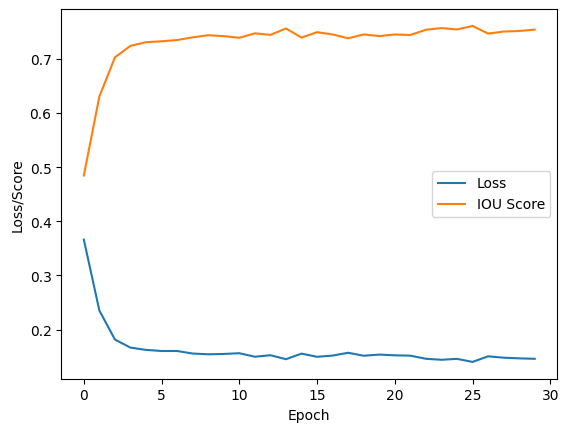

In [24]:
plt.plot(losses, label="Loss")
plt.plot(scores, label="IOU Score")
plt.xlabel("Epoch")
plt.ylabel("Loss/Score")
plt.legend()
plt.show()

## Test best saved model

In [25]:
# load best saved checkpoint
# best_model = torch.load('./synthia_sf_20_fpn.pth')
best_model = torch.load('./synthia_sf_30_fpn_with_test.pth')

In [26]:
test_dataset = Dataset(
    "/datasets/vedang/synthia/SYNTHIA-SF/SEQ1",
    "/datasets/vedang/scripts_synthia/",
    split='test', 
    mode='fine', 
    classes=CLASSES, 
    target_type='semantic',
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataloader = DataLoader(test_dataset)

In [27]:
len(test_dataset)

1112

In [79]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid:   0%|          | 3/1112 [00:04<28:47,  1.56s/it, dice_loss - 0.2359, iou_score - 0.6309]


KeyboardInterrupt: 

## Visualize predictions

In [28]:
test_dataset_vis = Dataset(
     "/datasets/vedang/synthia/SYNTHIA-SF/SEQ1",
    "/datasets/vedang/scripts_synthia/",
    split='test', 
    mode='fine', 
    classes=CLASSES, 
    target_type='semantic',
)

unlabeled
(20, 1088, 1920)


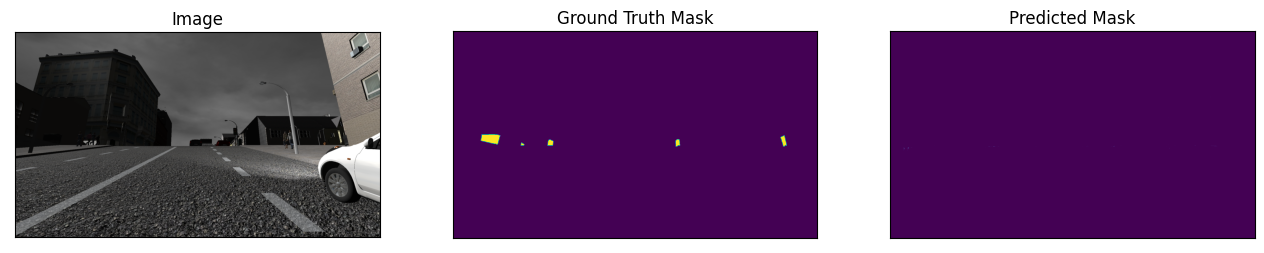

sky
(20, 1088, 1920)


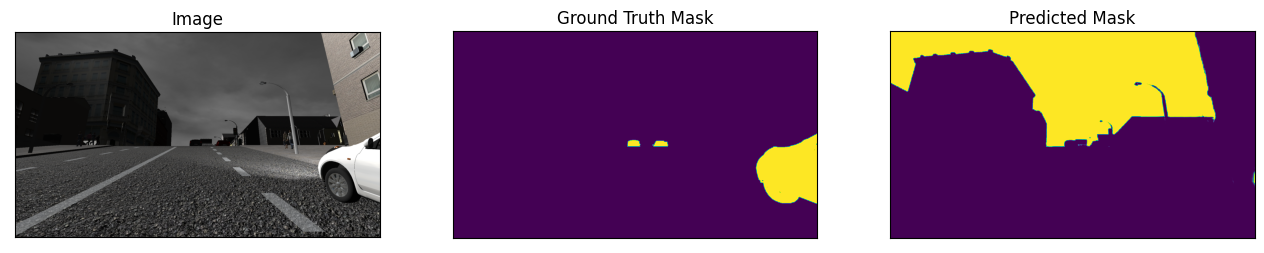

building
(20, 1088, 1920)


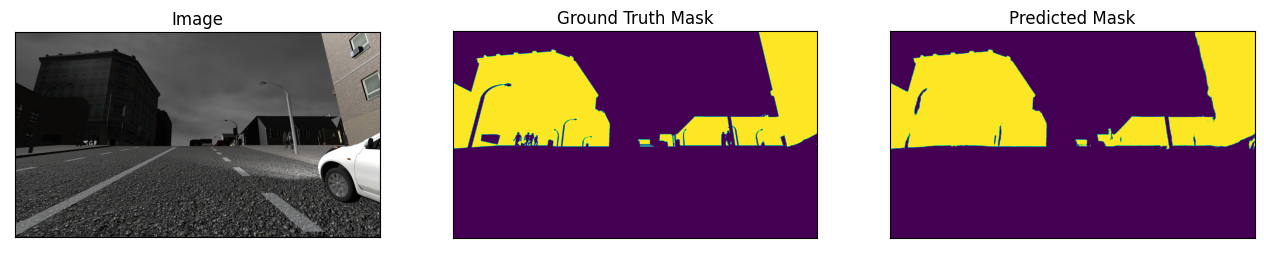

road
(20, 1088, 1920)


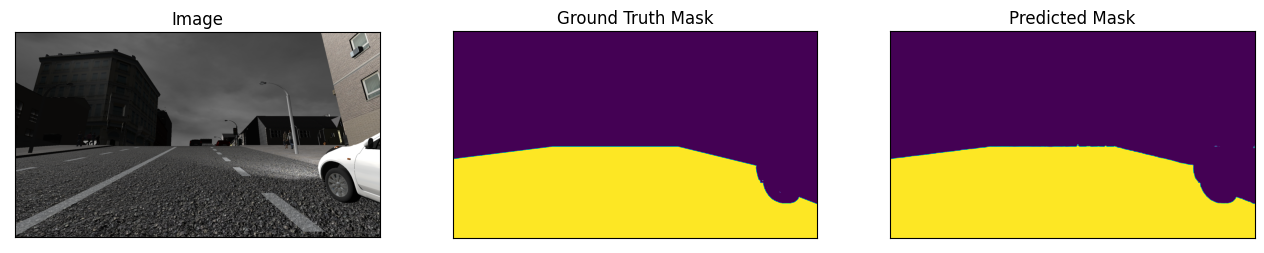

sidewalk
(20, 1088, 1920)


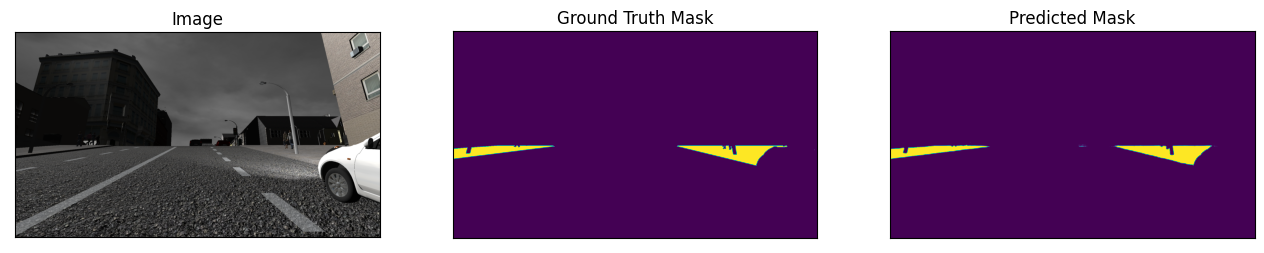

fence
(20, 1088, 1920)


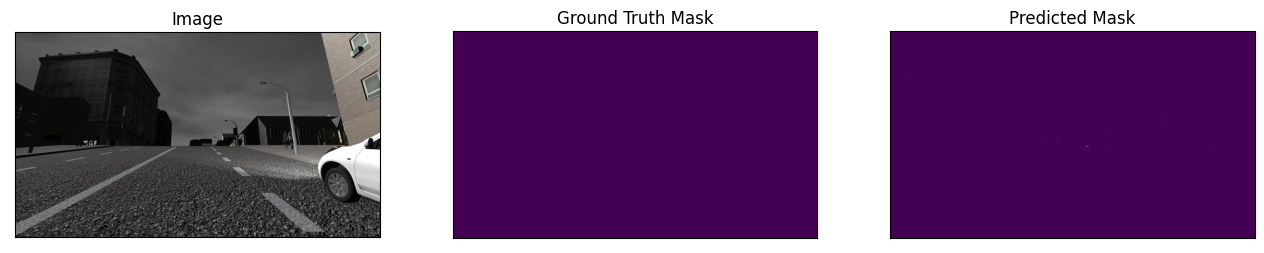

vegetation
(20, 1088, 1920)


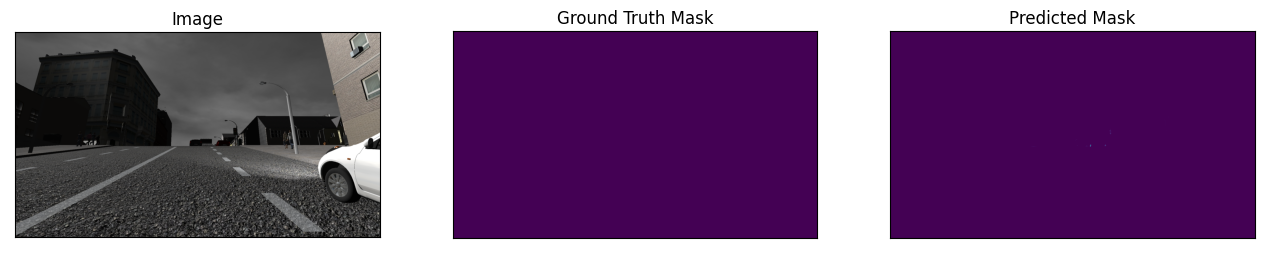

pole
(20, 1088, 1920)


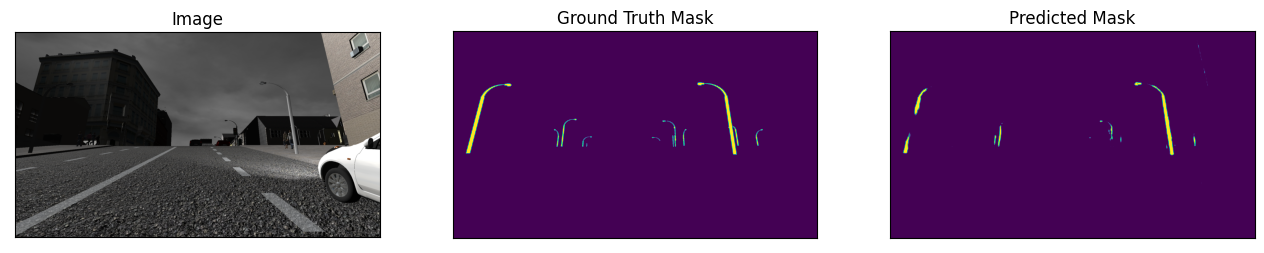

car
(20, 1088, 1920)


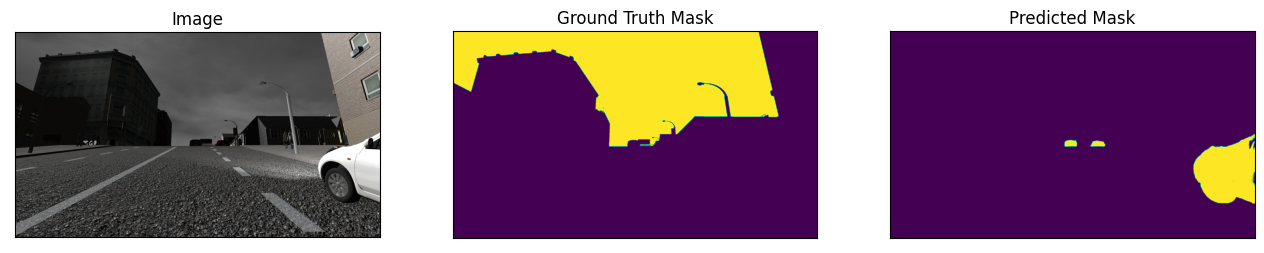

traffic sign
(20, 1088, 1920)


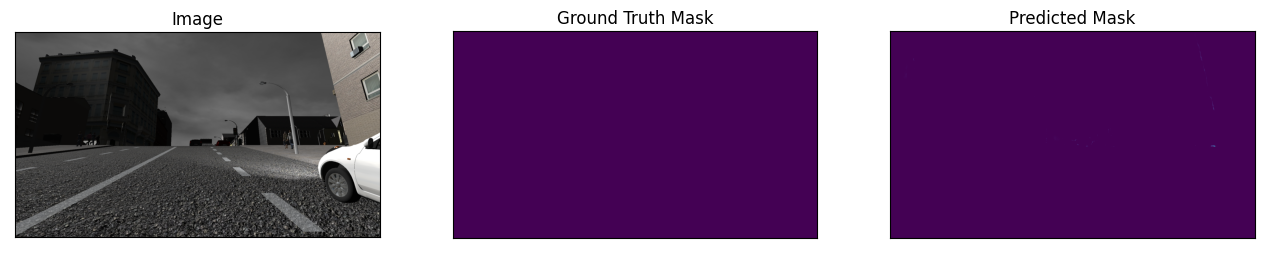

person
(20, 1088, 1920)


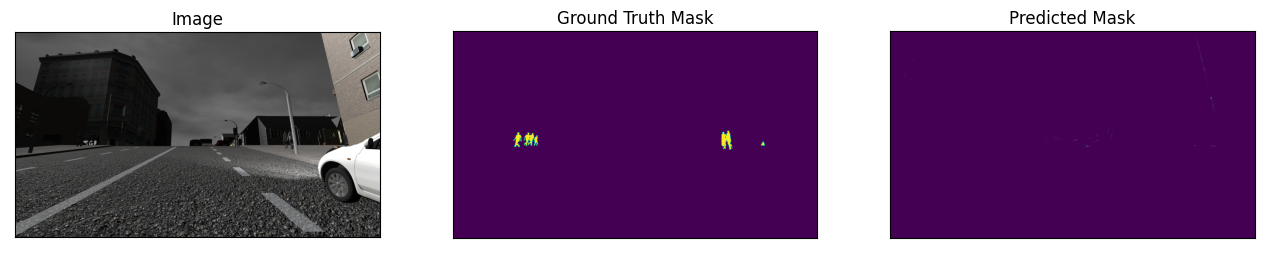

bicycle
(20, 1088, 1920)


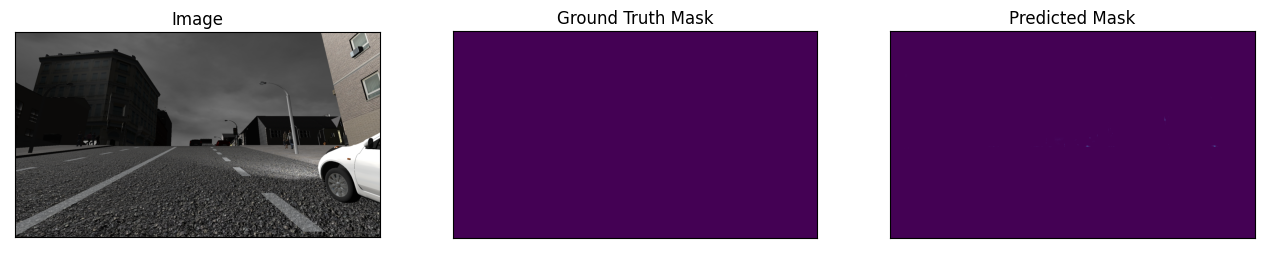

motorcycle
(20, 1088, 1920)


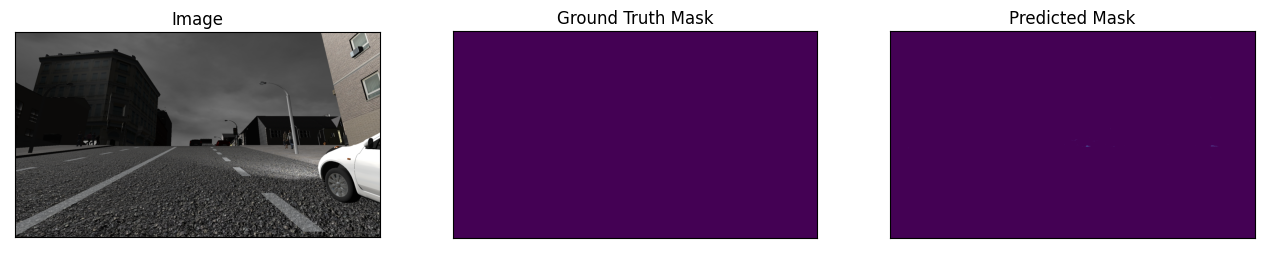

traffic light
(20, 1088, 1920)


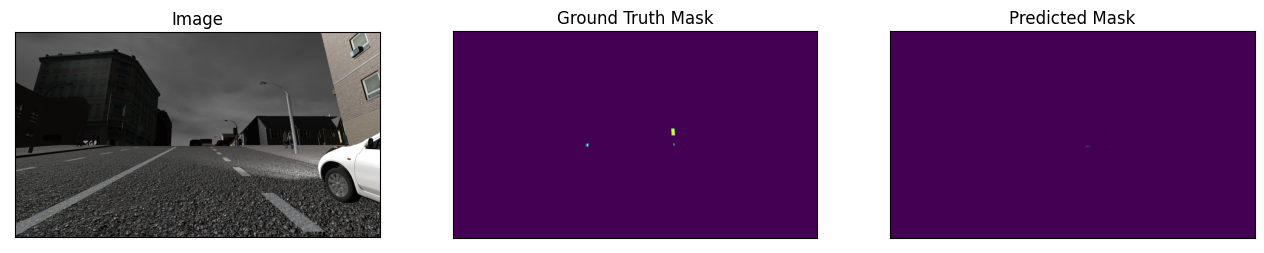

terrain
(20, 1088, 1920)


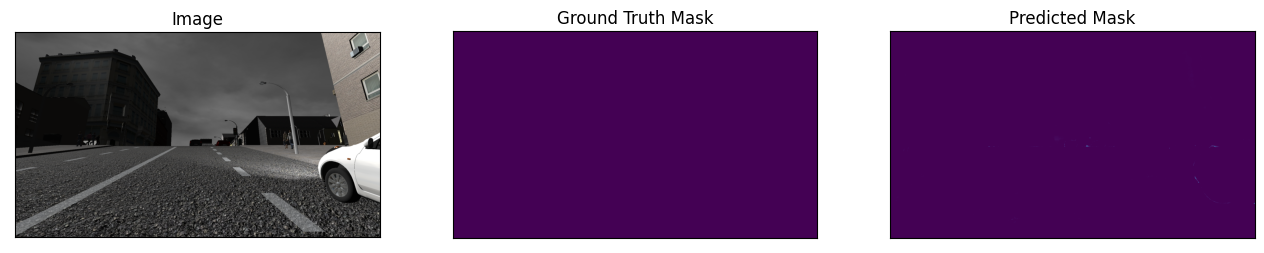

rider
(20, 1088, 1920)


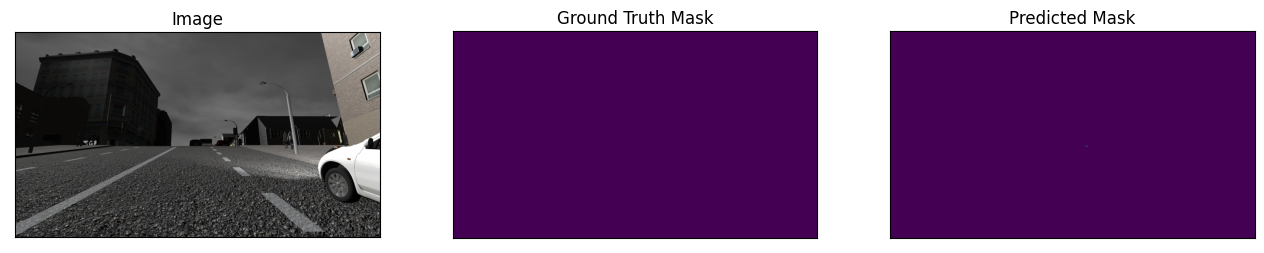

truck
(20, 1088, 1920)


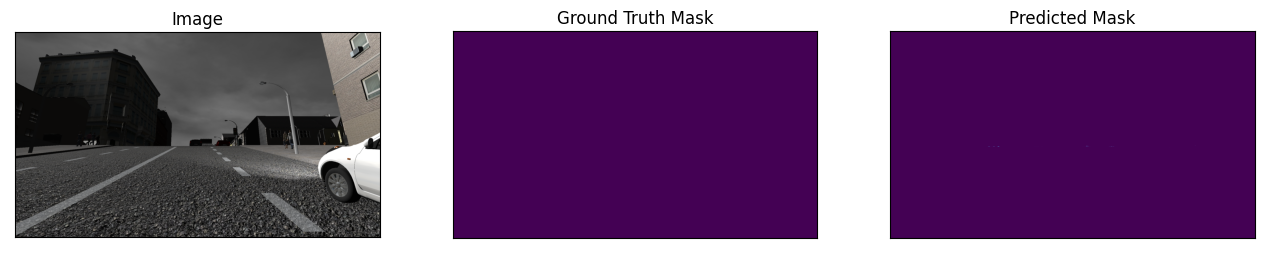

bus
(20, 1088, 1920)


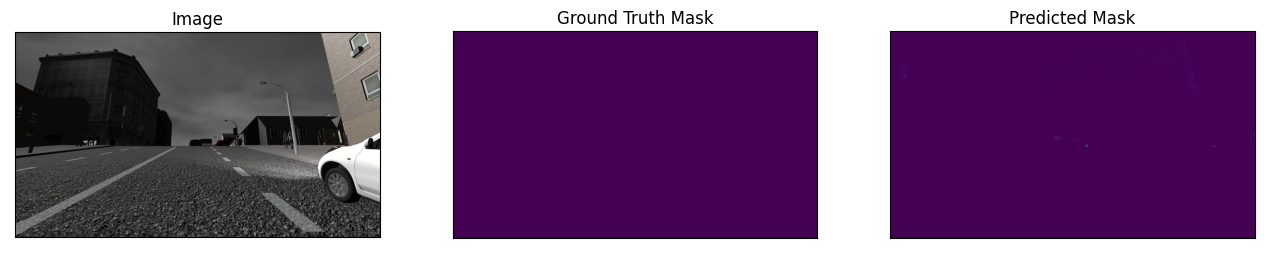

train
(20, 1088, 1920)


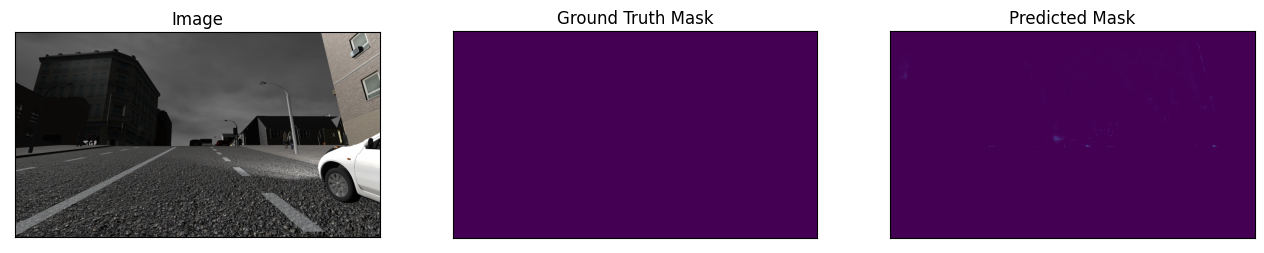

wall
(20, 1088, 1920)


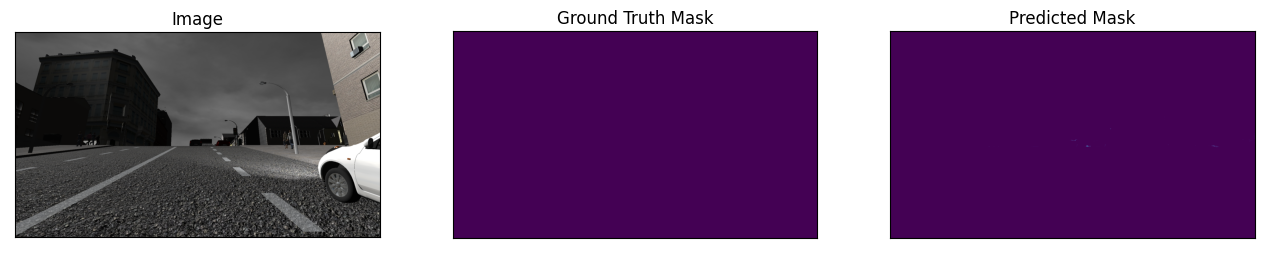

In [58]:
for index in range(len(CLASSES)):
    print(CLASSES[index])
#     n = np.random.choice(len(test_dataset))
    n=0
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)

    pr_mask = (pr_mask.squeeze().cpu().numpy())   
    print(gt_mask.shape)
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[index,:,:], 
        predicted_mask=pr_mask[index,:,:]
    )

In [29]:
# test_dataset = Dataset(
#     "/datasets/vedang/synthia/SYNTHIA-SF/SEQ1",
#     "/datasets/vedang/scripts_synthia/",
#     split='test', 
#     mode='fine', 
#     classes=CLASSES, 
#     target_type='semantic',
#     augmentation=get_validation_augmentation(), 
#     preprocessing=get_preprocessing(preprocessing_fn),
# )

In [30]:
import itertools
s = set(itertools.chain(test_dataset.drop_sky, test_dataset.drop_car, test_dataset.shift_sky, test_dataset.shift_car, test_dataset.swap_sky)) 
errors = np.array([1 if x in s else 0 for x in range(len(test_dataset))])

In [31]:
len(s), len(test_dataset)

(358, 1112)

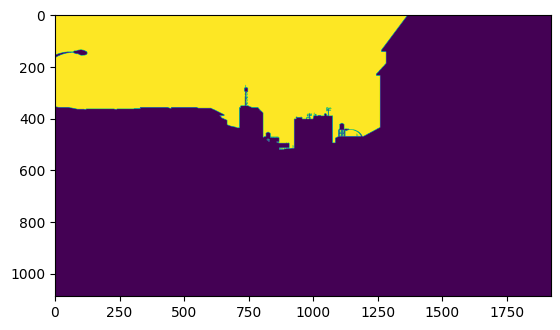

In [36]:
plt.imshow(test_dataset[52][1][1].squeeze())
plt.show()

In [37]:
errors

array([1, 0, 1, ..., 1, 0, 1])

This code differs from the original cityscapes code in the fact that we (1) Change the datatype to a smaller more efficient one and (2) We split the saving of the array into 6 arrays of size 28 to help with effeciency later 

In [42]:
#Preallocate memory
to_save = 1112
cls, h, w = 20, 1088, 1920 #Change this to shrink
gts=np.empty((139, h, w), dtype="int8")
prs_unrounded=np.empty((139, cls, h, w),dtype="float16")



count = 0
name = 0

for im in tqdm(range(to_save)):
    n = im   
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask_notrounded = (pr_mask.squeeze().cpu().numpy())
    gts[count] = np.argmax(gt_mask,axis=0).astype("int8")
    prs_unrounded[count] = pr_mask_notrounded.astype("float16")
    count+=1
    if count%139==0:
        name+=1
        if name>0:
            np.save(f"synthia_given_masks_{to_save}_{name}", gts)
            np.save(f"synthia_unrounded_predicted_masks_{to_save}_{name}", prs_unrounded)
            gts=np.empty((139, h, w), dtype="int8")
            prs_unrounded=np.empty((139, cls, h, w), dtype="float16")
            count=0

100%|██████████| 1112/1112 [1:11:40<00:00,  3.87s/it]


In [34]:
np.save(f"errors_{to_save}", errors)